In [96]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
from zipfile import ZipFile
zip_path = '/content/drive/MyDrive/data.zip'

extract_path = '/content/'

with ZipFile(zip_path, 'r') as z:
    z.extractall(path=extract_path)

In [4]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [5]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets

train_ids = load_text_ids('/content/drive/MyDrive/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [6]:
import random
# !pip install tensorflow
import tensorflow as tf
from PIL import Image

def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        # label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        img = img / 255.0
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape([299, 299, 3])
    y.set_shape([])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

In [7]:
!pip install tensorflow opencv-python

<h3>Empirical Regularization</h3>
    
Randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation.

Based on this dataset, I believe *random contrast adjustment, rotation, and flipping* would be the best. The model will learn based on different orientations of features, which could be helpful for satellite images. It will further learn from different parts of the image at different orientations by flipping, which could identify terrain features better. The model will learn to be more robust to changes in lighting, as well.

In [9]:
# Helper methods for image augmentation
def random_contrast(image, lower=0.5, upper=1.5):
    factor = np.random.uniform(lower, upper)
    return tf.image.adjust_contrast(image, factor)

def random_flip(image, label):
    image = tf.image.random_flip_up_down(image)
    return image, label

def random_zoom(image, label):
    # Extract the height and width from the shape of the image
    shape = tf.shape(image)
    height, width = tf.cast(shape[-3], tf.float32), tf.cast(shape[-2], tf.float32)

    zoom_factor = tf.random.uniform([], 0.8, 1.2)
    new_height, new_width = tf.cast(height * zoom_factor, tf.int32), tf.cast(width * zoom_factor, tf.int32)

    # Resize and then crop the image
    image = tf.image.resize(image, [new_height, new_width])
    image = tf.image.random_crop(image, size=[tf.cast(height, tf.int32), tf.cast(width, tf.int32), 3])

    return image, label

def random_rotation(image, label):
    image = tf.image.rot90(image, k=np.random.randint(4))
    return image, label

def random_translate(image):
    image = tf.image.random_translation(image, 0.2, 0.2)
    return image

def image_augmentation(image, label):
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    # Selectively augment data to prevent all augmentations on every image
    augment = tf.random.uniform(shape =[], minval=0, maxval=3, dtype=tf.int32)  # 33.33% chance to augment image
    if augment == 1: #1/9 of the entire data set will be contrast adjusted, rotated, or flipped.
        choice = tf.random.uniform(shape = [], minval=0, maxval=3, dtype=tf.int32)
        if choice == 0:
            image = random_contrast(image)
        elif choice == 1:
            image, label = random_rotation(image, label)
        elif choice == 2:
            image, label = random_flip(image, label)

    # Normalize the image
    image /= 255.0

    return image, label

In [10]:
augmented_train_dataset = tf_dataset_train.map(image_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)

<h3> Train a three-layer CNN followed by a dense layer on the data </h3>

In [59]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    #1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    #2
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    #3
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Use cross entropy loss
model.compile(optimizer=Adam(learning_rate=0.00001),loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'),
                       metrics.Recall(name='recall')])

# Perform early stopping using the validation set
early_stopping = EarlyStopping(monitor='val_loss', patience=7)
model_checkpoint = ModelCheckpoint('best_CNN_MLP_model.tf', monitor='val_loss', save_best_only=True, save_format ='tf')

In [60]:
# Train the CNN & MLP model for at least 20 epochs with the train data set
history = model.fit(augmented_train_dataset, epochs = 20, validation_data = tf_dataset_val,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
928/928 [==============================] - 162s 172ms/step - loss: 29.1686 - accuracy: 0.7377 - precision: 0.7700 - recall: 0.7896 - val_loss: 443.5508 - val_accuracy: 0.2375 - val_precision: 0.2540 - val_recall: 0.7068
Epoch 2/20
928/928 [==============================] - 155s 167ms/step - loss: 16.4830 - accuracy: 0.7954 - precision: 0.8172 - recall: 0.8398 - val_loss: 810.1567 - val_accuracy: 0.2307 - val_precision: 0.2526 - val_recall: 0.7101
Epoch 3/20
928/928 [==============================] - 159s 172ms/step - loss: 10.3843 - accuracy: 0.8201 - precision: 0.8346 - recall: 0.8653 - val_loss: 371.1178 - val_accuracy: 0.3037 - val_precision: 0.2739 - val_recall: 0.7051
Epoch 4/20
928/928 [==============================] - 157s 169ms/step - loss: 7.5766 - accuracy: 0.8376 - precision: 0.8461 - recall: 0.8845 - val_loss: 590.0267 - val_accuracy: 0.2590 - val_precision: 0.2609 - val_recall: 0.7106
Epoch 5/20
928/928 [==============================] - 157s 169ms/step - loss:

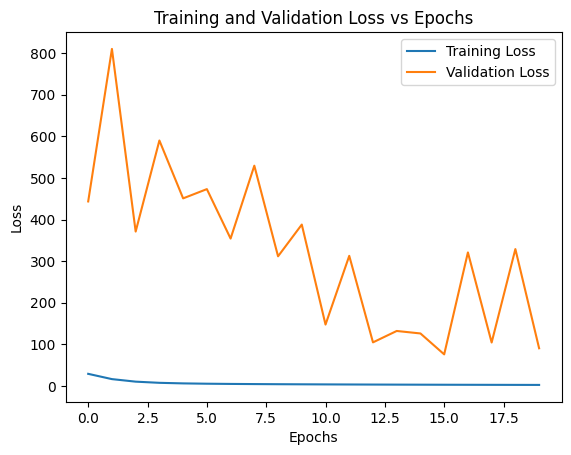

In [61]:
# Plot training and validation errors vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
def calculate_f1_score(precision, recall):
  return 2 * (precision * recall) / (precision + recall)

train_precision = history.history['precision'][-1]
train_recall = history.history['recall'][-1]
train_f1_score = calculate_f1_score(train_precision, train_recall)

trainCNN_MLP = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [train_precision, train_recall, train_f1_score]
}

In [63]:
from tensorflow.keras.models import load_model

best_model = load_model('best_CNN_MLP_model.tf')

val_loss, val_accuracy, val_precision, val_recall = model.evaluate(tf_dataset_val)
val_f1_score = calculate_f1_score(val_precision, val_recall)

validateCNN_MLP = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [val_precision, val_recall, val_f1_score]
}


353/353 [==============================] - 37s 104ms/step - loss: 90.6276 - accuracy: 0.6107 - precision: 0.4358 - recall: 0.7126


In [93]:
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(tf_dataset_test)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

testCNN_MLP = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [test_precision, test_recall, f1_score]
}

401/401 [==============================] - 44s 109ms/step - loss: 167.0232 - accuracy: 0.6235 - precision: 0.9290 - recall: 0.4608


In [97]:
def evaluate_model(model, dataset, show_output=True):
  y_true = []
  y_pred = []
  for images, labels in dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

  report = classification_report(y_true, y_pred)
  return report

CNN_MLP_train_metrics = pd.DataFrame(trainCNN_MLP)
print("Train Set Metrics:")
print(CNN_MLP_train_metrics)
train_report = evaluate_model(best_model, tf_dataset_train)
print(train_report)

CNN_MLP_val_metrics = pd.DataFrame(validateCNN_MLP)
print("\nValidation Set Metrics:")
print(CNN_MLP_val_metrics)
val_report = evaluate_model(best_model, tf_dataset_val)
print(val_report)

CNN_MLP_test_metrics = pd.DataFrame(testCNN_MLP)
print("\nTest Set Metrics:")
print(CNN_MLP_test_metrics)
test_report = evaluate_model(best_model, tf_dataset_test)
print(test_report)

Train Set Metrics:
      Metric     Value
0  Precision  0.922324
1     Recall  0.933903
2   F1 Score  0.928077
              precision    recall  f1-score   support

           0       0.41      1.00      0.58     12235
           1       0.00      0.00      0.00     17444

    accuracy                           0.41     29679
   macro avg       0.21      0.50      0.29     29679
weighted avg       0.17      0.41      0.24     29679


Validation Set Metrics:
      Metric     Value
0  Precision  0.435837
1     Recall  0.712555
2   F1 Score  0.540857
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      7654
           1       0.00      0.00      0.00      3632

    accuracy                           0.68     11286
   macro avg       0.34      0.50      0.40     11286
weighted avg       0.46      0.68      0.55     11286


Test Set Metrics:
      Metric     Value
0  Precision  0.929000
1     Recall  0.460797
2   F1 Score  0.616033
       

## Transfering Learning
using pre-trained models EfficientNetB0, ResNet50, and VGG16

In [80]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

# Load EfficientNetB0 without the top layer
base_model_efficientNet = EfficientNetB0(weights='imagenet', include_top=False)
for layer in base_model_efficientNet.layers:
  layer.trainable = False

efficientNet = models.Sequential([
    base_model_efficientNet,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'), #ReLU activation functions in the last layer
    layers.Dropout(0.3), # Dropout rate of 30%
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])
efficientNet.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'),
                       metrics.Recall(name='recall')])

# Load ResNet50 without the top layer
base_model_resnet = ResNet50(weights='imagenet', include_top=False)
for layer in base_model_resnet.layers:
  layer.trainable = False

resnet_model = models.Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])
resnet_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'),
                       metrics.Recall(name='recall')])

# Load VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False)
for layer in base_model_vgg16.layers:
  layer.trainable = False

model_vgg16 = models.Sequential([
    base_model_vgg16,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_vgg16.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'),
                       metrics.Recall(name='recall')])

In [71]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=2)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

efficientNetHistory = efficientNet.fit(augmented_train_dataset,
                    epochs=12, batch_size=8,
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/12
928/928 [==============================] - 173s 176ms/step - loss: 0.7303 - accuracy: 0.5559 - precision: 0.5921 - recall: 0.7859 - val_loss: 0.7669 - val_accuracy: 0.3218 - val_precision: 0.3218 - val_recall: 1.0000
Epoch 2/12
928/928 [==============================] - 163s 175ms/step - loss: 0.6893 - accuracy: 0.5708 - precision: 0.5883 - recall: 0.8982 - val_loss: 0.8043 - val_accuracy: 0.3218 - val_precision: 0.3218 - val_recall: 1.0000
Epoch 3/12
928/928 [==============================] - 163s 175ms/step - loss: 0.6841 - accuracy: 0.5762 - precision: 0.5872 - recall: 0.9386 - val_loss: 0.7922 - val_accuracy: 0.3218 - val_precision: 0.3218 - val_recall: 1.0000
Epoch 4/12
928/928 [==============================] - 165s 177ms/step - loss: 0.6829 - accuracy: 0.5796 - precision: 0.5881 - recall: 0.9503 - val_loss: 0.7761 - val_accuracy: 0.3218 - val_precision: 0.3218 - val_recall: 1.0000
Epoch 5/12
928/928 [==============================] - 162s 174ms/step - loss: 0.6830 - a

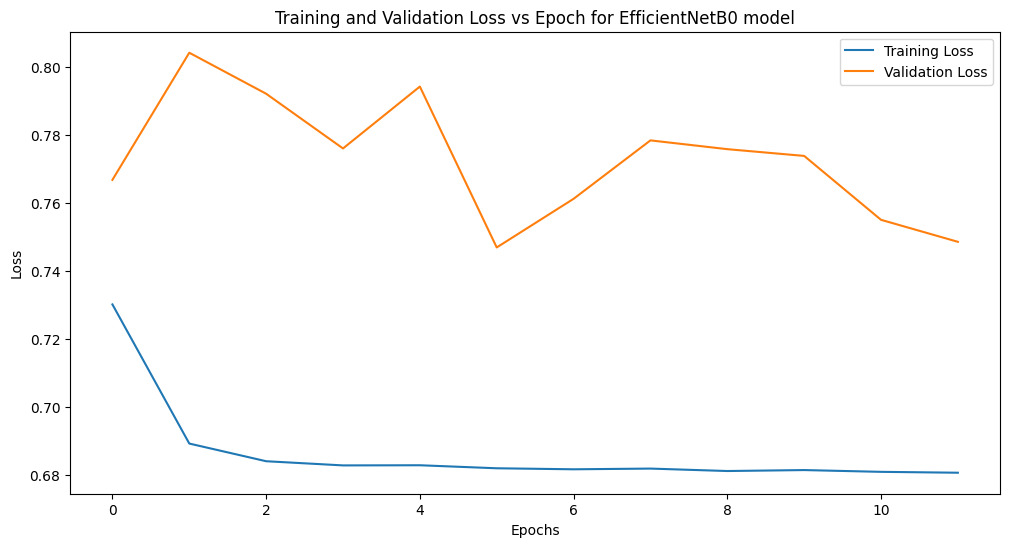

In [72]:
# Plot the training and validation errors vs. epochs for EfficientNetB0 model
plt.figure(figsize=(12, 6))
plt.plot(efficientNetHistory.history['loss'], label='Training Loss')
plt.plot(efficientNetHistory.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epoch for EfficientNetB0 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_resnet.h5', monitor='val_loss', save_best_only=True)

resnet_modelHistory = resnet_model.fit(augmented_train_dataset,
                    epochs=12, batch_size=8,
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/12
928/928 [==============================] - 192s 201ms/step - loss: 0.6002 - accuracy: 0.6738 - precision: 0.6924 - recall: 0.8009 - val_loss: 114.3473 - val_accuracy: 0.7679 - val_precision: 0.7430 - val_recall: 0.4259
Epoch 2/12
928/928 [==============================] - 186s 200ms/step - loss: 0.5858 - accuracy: 0.6784 - precision: 0.7007 - recall: 0.7905 - val_loss: 295.2837 - val_accuracy: 0.4347 - val_precision: 0.3489 - val_recall: 0.8733
Epoch 3/12
928/928 [==============================] - 187s 202ms/step - loss: 0.5776 - accuracy: 0.6828 - precision: 0.7053 - recall: 0.7907 - val_loss: 113.7767 - val_accuracy: 0.7929 - val_precision: 0.8038 - val_recall: 0.4716
Epoch 4/12
928/928 [==============================] - 187s 201ms/step - loss: 0.5765 - accuracy: 0.6867 - precision: 0.7081 - recall: 0.7947 - val_loss: 295.3467 - val_accuracy: 0.7258 - val_precision: 1.0000 - val_recall: 0.1479
Epoch 5/12
928/928 [==============================] - 185s 199ms/step - loss: 0.

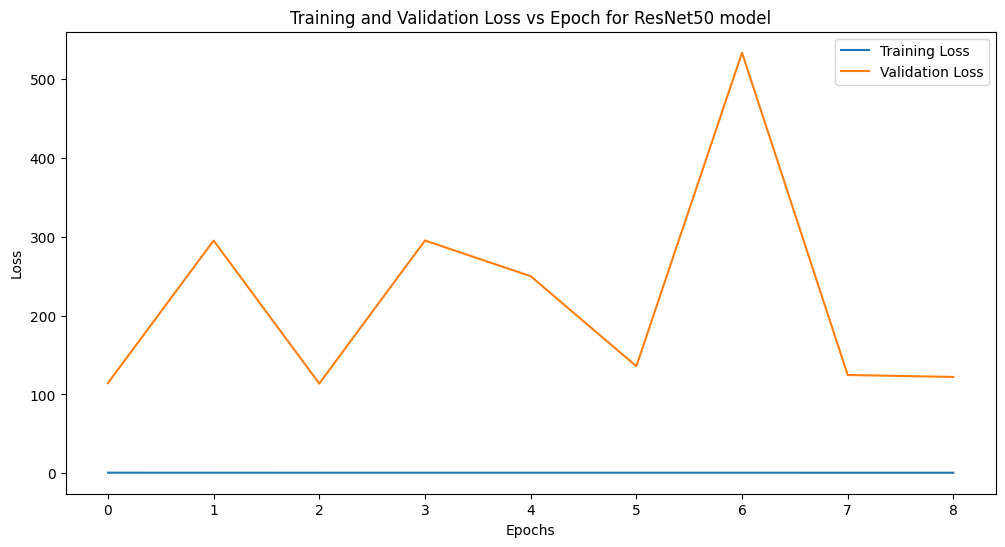

In [82]:
# Plot the training and validation errors vs. epochs for ResNet50 model
plt.figure(figsize=(12, 6))
plt.plot(resnet_modelHistory.history['loss'], label='Training Loss')
plt.plot(resnet_modelHistory.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epoch for ResNet50 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_vgg16_.h5', monitor='val_loss', save_best_only=True)

vgg16_modelHistory = model_vgg16.fit(augmented_train_dataset,
                    epochs=10, batch_size=8,
                    validation_data=tf_dataset_val,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
928/928 [==============================] - 210s 224ms/step - loss: 0.6054 - accuracy: 0.6760 - precision: 0.6724 - recall: 0.8750 - val_loss: 85.1808 - val_accuracy: 0.7255 - val_precision: 0.7954 - val_recall: 0.1980
Epoch 2/10
928/928 [==============================] - 212s 229ms/step - loss: 0.5462 - accuracy: 0.7107 - precision: 0.7162 - recall: 0.8411 - val_loss: 225.3559 - val_accuracy: 0.7072 - val_precision: 0.6325 - val_recall: 0.2156
Epoch 3/10
928/928 [==============================] - 213s 229ms/step - loss: 0.5086 - accuracy: 0.7405 - precision: 0.7500 - recall: 0.8375 - val_loss: 352.4580 - val_accuracy: 0.6920 - val_precision: 0.5581 - val_recall: 0.2062
Epoch 4/10
928/928 [==============================] - 212s 228ms/step - loss: 0.4950 - accuracy: 0.7489 - precision: 0.7623 - recall: 0.8323 - val_loss: 456.3989 - val_accuracy: 0.6896 - val_precision: 0.5574 - val_recall: 0.1724
Epoch 5/10
928/928 [==============================] - 211s 227ms/step - loss: 0.4

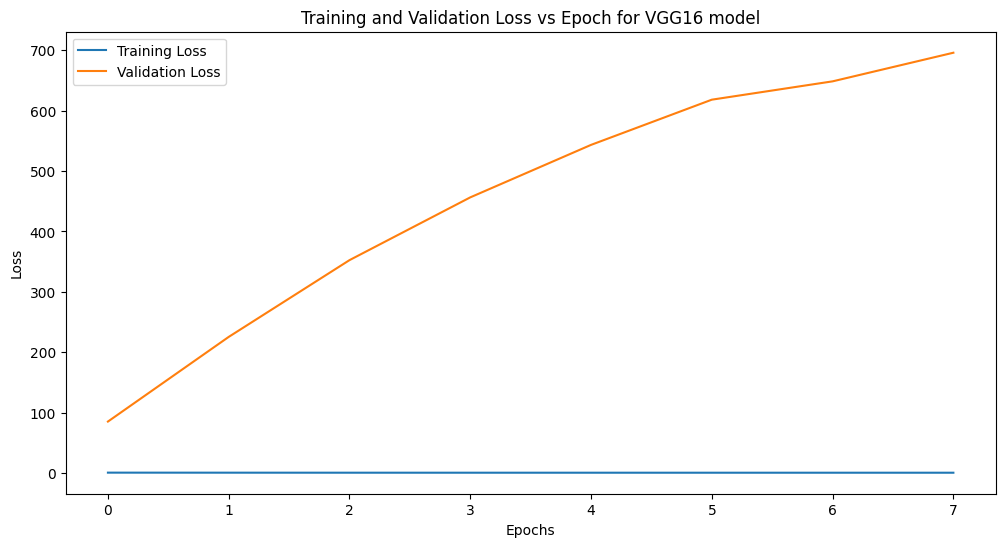

In [84]:
# Plot the training and validation errors vs. epochs for VGG16 model
plt.figure(figsize=(12, 6))
plt.plot(vgg16_modelHistory.history['loss'], label='Training Loss')
plt.plot(vgg16_modelHistory.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epoch for VGG16 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

EfficientNetB0

In [85]:
train_precision = efficientNetHistory.history['precision'][-1]
train_recall = efficientNetHistory.history['recall'][-1]
train_f1_score = calculate_f1_score(train_precision, train_recall)

train_efficientnet = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [train_precision, train_recall, train_f1_score]
}

best_model_efficientnet = load_model('best_model.h5')

val_loss, val_accuracy, val_precision, val_recall = best_model_efficientnet.evaluate(tf_dataset_val)
val_f1_score = calculate_f1_score(val_precision, val_recall)

val_efficientnet = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [val_precision, val_recall, val_f1_score]
}

test_loss, test_accuracy, test_precision, test_recall = best_model_efficientnet.evaluate(tf_dataset_test)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

test_efficientnet = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [test_precision, test_recall, f1_score]
}

401/401 [==============================] - 51s 128ms/step - loss: 0.6606 - accuracy: 0.6555 - precision: 0.6555 - recall: 1.0000


In [98]:
efficientNet_train_metrics = pd.DataFrame(train_efficientnet)
print("Train Set Metrics:")
print(efficientNet_train_metrics)
train_report = evaluate_model(best_model_efficientnet, tf_dataset_train)
print(train_report)

efficientNet_val_metrics = pd.DataFrame(val_efficientnet)
print("\nValidation Set Metrics:")
print(efficientNet_val_metrics)
val_report = evaluate_model(best_model_efficientnet, tf_dataset_val)
print(val_report)

efficientNet_test_metrics = pd.DataFrame(test_efficientnet)
print("\nTest Set Metrics:")
print(efficientNet_test_metrics)
test_report = evaluate_model(best_model_efficientnet, tf_dataset_test)
print(test_report)


Train Set Metrics:
      Metric     Value
0  Precision  0.587695
1     Recall  0.978503
2   F1 Score  0.734340
              precision    recall  f1-score   support

           0       0.41      1.00      0.58     12235
           1       0.00      0.00      0.00     17444

    accuracy                           0.41     29679
   macro avg       0.21      0.50      0.29     29679
weighted avg       0.17      0.41      0.24     29679


Validation Set Metrics:
      Metric     Value
0  Precision  0.321815
1     Recall  1.000000
2   F1 Score  0.486929
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      7654
           1       0.00      0.00      0.00      3632

    accuracy                           0.68     11286
   macro avg       0.34      0.50      0.40     11286
weighted avg       0.46      0.68      0.55     11286


Test Set Metrics:
      Metric     Value
0  Precision  0.655463
1     Recall  1.000000
2   F1 Score  0.791879
       

ResNet50

In [87]:
train_precision = resnet_modelHistory.history['precision'][-1]
train_recall = resnet_modelHistory.history['recall'][-1]
train_f1_score = calculate_f1_score(train_precision, train_recall)

train_resnet = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [train_precision, train_recall, train_f1_score]
}

best_model_resnet = load_model('best_model_resnet.h5')

val_loss, val_accuracy, val_precision, val_recall = best_model_resnet.evaluate(tf_dataset_val)
val_f1_score = calculate_f1_score(val_precision, val_recall)

val_resnet = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [val_precision, val_recall, val_f1_score]
}

test_loss, test_accuracy, test_precision, test_recall = best_model_resnet.evaluate(tf_dataset_test)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

test_resnet = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [test_precision, test_recall, f1_score]
}

401/401 [==============================] - 59s 145ms/step - loss: 485.4457 - accuracy: 0.6419 - precision: 0.9591 - recall: 0.4739


In [99]:
resnet_train_metrics = pd.DataFrame(train_resnet)
print("Train Set Metrics:")
print(resnet_train_metrics)
train_report = evaluate_model(best_model_resnet, tf_dataset_train)
print(train_report)

resnet_val_metrics = pd.DataFrame(val_resnet)
print("\nValidation Set Metrics:")
print(resnet_val_metrics)
val_report = evaluate_model(best_model_resnet, tf_dataset_val)
print(val_report)

resnet_test_metrics = pd.DataFrame(test_resnet)
print("\nTest Set Metrics:")
print(resnet_test_metrics)
test_report = evaluate_model(best_model_resnet, tf_dataset_test)
print(test_report)

Train Set Metrics:
      Metric     Value
0  Precision  0.715196
1     Recall  0.798097
2   F1 Score  0.754376
              precision    recall  f1-score   support

           0       0.41      1.00      0.58     12235
           1       0.00      0.00      0.00     17444

    accuracy                           0.41     29679
   macro avg       0.21      0.50      0.29     29679
weighted avg       0.17      0.41      0.24     29679


Validation Set Metrics:
      Metric     Value
0  Precision  0.803848
1     Recall  0.471641
2   F1 Score  0.594482
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      7654
           1       0.00      0.00      0.00      3632

    accuracy                           0.68     11286
   macro avg       0.34      0.50      0.40     11286
weighted avg       0.46      0.68      0.55     11286


Test Set Metrics:
      Metric     Value
0  Precision  0.959066
1     Recall  0.473885
2   F1 Score  0.634337
       

VGG16

In [89]:
train_precision = vgg16_modelHistory.history['precision'][-1]
train_recall = vgg16_modelHistory.history['recall'][-1]
train_f1_score = calculate_f1_score(train_precision, train_recall)

train_vgg16 = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [train_precision, train_recall, train_f1_score]
}

best_model_vgg16 = load_model('best_model_vgg16_.h5')

val_loss, val_accuracy, val_precision, val_recall = best_model_vgg16.evaluate(tf_dataset_val)
val_f1_score = calculate_f1_score(val_precision, val_recall)

val_vgg16 = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [val_precision, val_recall, val_f1_score]
}

test_loss, test_accuracy, test_precision, test_recall = best_model_vgg16.evaluate(tf_dataset_test)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

test_vgg16 = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Value': [test_precision, test_recall, f1_score]
}

401/401 [==============================] - 65s 161ms/step - loss: 86.1798 - accuracy: 0.5415 - precision: 0.8419 - recall: 0.3700


In [100]:
vgg16_train_metrics = pd.DataFrame(train_vgg16)
print("Train Set Metrics:")
print(vgg16_train_metrics)
train_report = evaluate_model(best_model_vgg16, tf_dataset_train)
print(train_report)

vgg16_val_metrics = pd.DataFrame(val_vgg16)
print("\nValidation Set Metrics:")
print(vgg16_val_metrics)
val_report = evaluate_model(best_model_vgg16, tf_dataset_val)
print(val_report)

vgg16_test_metrics = pd.DataFrame(test_vgg16)
print("\nTest Set Metrics:")
print(vgg16_test_metrics)
test_report = evaluate_model(best_model_vgg16, tf_dataset_test)
print(test_report)

Train Set Metrics:
      Metric     Value
0  Precision  0.782270
1     Recall  0.840748
2   F1 Score  0.810455
              precision    recall  f1-score   support

           0       0.41      1.00      0.58     12235
           1       0.00      0.00      0.00     17444

    accuracy                           0.41     29679
   macro avg       0.21      0.50      0.29     29679
weighted avg       0.17      0.41      0.24     29679


Validation Set Metrics:
      Metric     Value
0  Precision  0.795354
1     Recall  0.197963
2   F1 Score  0.317019
              precision    recall  f1-score   support

           0       0.68      1.00      0.81      7654
           1       0.00      0.00      0.00      3632

    accuracy                           0.68     11286
   macro avg       0.34      0.50      0.40     11286
weighted avg       0.46      0.68      0.55     11286


Test Set Metrics:
      Metric     Value
0  Precision  0.841906
1     Recall  0.370018
2   F1 Score  0.514092
       

<h3>Compare the results of Transfer Learning to CNN + MLP </h3>

**Evaluating CNN/MLP**
1. Train Set: High precision (0.922) and recall (0.934), which led to a high F1 Score (0.928).
2. Validation Set: Precision drops a lot (0.436), but recall remains relatively high (0.713), which resulted in a moderate F1 Score (0.541).
3. Test Set: Good precision (0.929) but low recall (0.461), which led to a moderate F1 Score (0.616).

It looks like the CNN + MLP model is overfitting the training data, based on the high F1 score for train set, but much lower performance on the validation and test sets.

**Evaluating EfficientNetB0**
1. Train Set: Lower precision (0.588) but very high recall (0.979), which led to a decent F1 Score (0.734).
2. Validation Set: Low precision (0.322) and high recall (1.000), which resulted in a lower F1 Score (0.487).
3. Test Set: Moderate precision (0.655) and high recall (1.000), which led to a good F1 Score (0.792).

**Evaluating ResNet50**
1. Train Set: Moderate precision (0.715) and recall (0.798), which resulted in a good F1 Score (0.754).
2. Validation Set: High precision (0.804) but lower recall (0.472), which led to a moderate F1 Score (0.594).
3. Test Set: Very high precision (0.959) but lower recall (0.474), which led to a moderate F1 Score (0.634).

**Evaluating VGG16**
1. Train Set: Good precision (0.782) and recall (0.841), which led to a high F1 Score (0.810).
2. Validation Set: High precision (0.795) but very low recall (0.198), resulted in a low F1 Score (0.317).
3. Test Set: Good precision (0.842) but lower recall (0.370), which resulted in a moderate F1 Score (0.514).

**Overall Analysis**
1. The transfer learning models, especially EfficientNetB0 and ResNet50, trend towards a higher recall value with varying precision values. These models seem to be better at identifying positive cases (frost), but falsely identify negative cases as positive (seen in the low precision values).
2. The CNN + MLP model, while showing high precision and recall on the training set, fails to generalize well on both validation and test data, which indicates overfitting.
3. ResNet50 and VGG16 show more balanced performance across precision and recall, particularly on the test set, compared to EfficientNetB0, which seems to be biased towards high recall.

Since the CNN + MLP model shows signs of overfitting, the transfer learning models, particularly ResNet50 and VGG16, offer a more balanced trade-off between precision and recall, which would make them more reliable for generalization on frost detection in Martian HiRISE images. The high recall trend of the Transfer Learning models are helpful for applications where missing a positive case (not detecting frost) would be more harmful than identifying a false positive.